In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import isnan

sns.set()

In [33]:
output_file = 'results/pruebas/test'

total_metrics = pd.read_csv(f'{output_file}.csv')

total_metrics["n_features"] = total_metrics.selected_features.apply(eval).apply(len)

total_metrics.drop("dataset_name", inplace=True, axis=1)

In [34]:
model_params = [col for col in total_metrics.columns if 'model_params' in col or 'selection_params' in col]
grouped = total_metrics.groupby(['dataset', 'selection_name', 'model_name', *model_params], dropna=False)[["mean_absolute_error", "mean_squared_error", "mean_squared_error_valid", "duration"]].mean()
best_results = grouped.loc[grouped.groupby(['dataset', 'selection_name', 'model_name'], dropna=False).mean_squared_error_valid.idxmin()].reset_index()

best_results.pivot(index="dataset", columns="model_name", values=["mean_absolute_error", "mean_squared_error"]).round(2)

mean_absolute_error              mean_squared_error             
model_name      customboosting randomforest     customboosting randomforest
dataset                                                                    
ETTh1                     4.02         1.62              29.13         4.42
ETTh2                     6.41         5.23              67.89        49.50
demand                 1355.43      1025.42         3785890.80   2383760.06
torneo                   21.73        22.40             792.32       815.89

In [35]:
best_results.pivot(index="dataset", columns="model_name", values=["duration"]).round(2)

duration             
model_name customboosting randomforest
dataset                               
ETTh1                0.33         2.26
ETTh2                0.35         3.63
demand               1.06         3.39
torneo               1.62        31.86

In [36]:
best_results.pivot(index="dataset", columns="model_name", values=["model_params_max_depth", "model_params_n_estimators"]).round(2)

model_params_max_depth              model_params_n_estimators  \
model_name         customboosting randomforest            customboosting   
dataset                                                                    
ETTh1                           3            3                        10   
ETTh2                           3            5                        10   
demand                          3            9                        50   
torneo                          3            9                        10   

                         
model_name randomforest  
dataset                  
ETTh1               100  
ETTh2               100  
demand              100  
torneo              100

<Figure size 1440x1440 with 0 Axes>

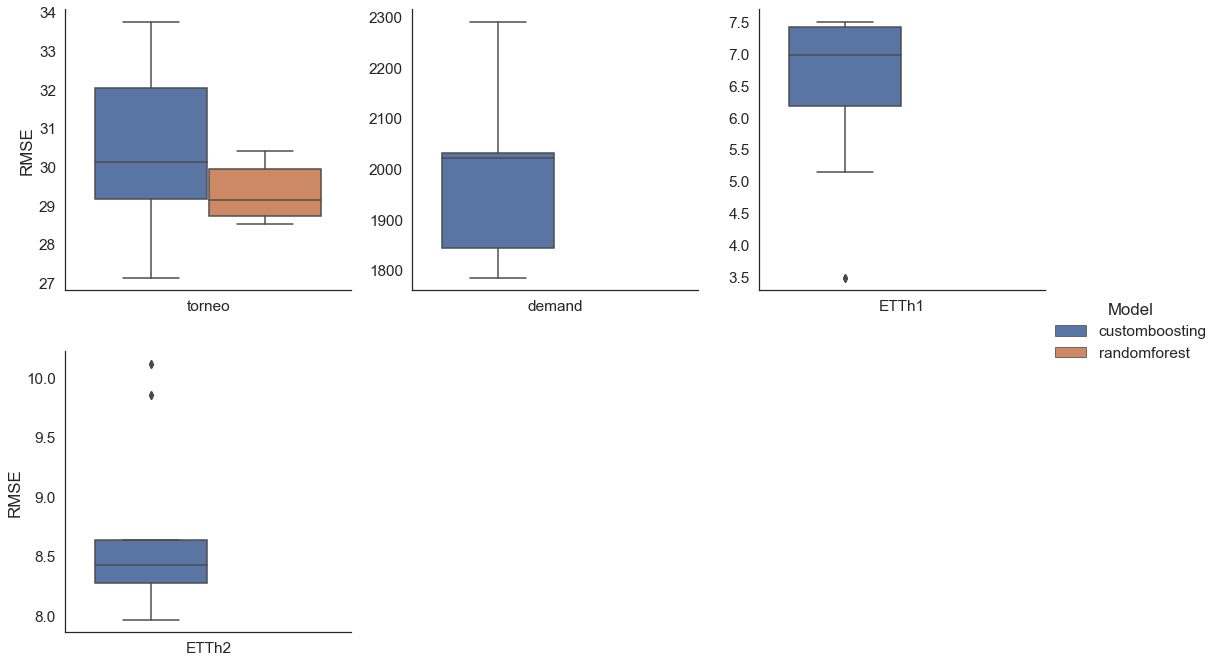

In [22]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
#total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)
total_metrics = total_metrics.rename({'model_name': 'Model', 'root_mean_squared_error': 'RMSE', 'n_features': '# Features'}, axis=1)
g = sns.catplot(data=total_metrics, kind='box', x='dataset', y="RMSE", col='dataset', hue='Model', sharex=False, sharey=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.show()

<Figure size 1440x1440 with 0 Axes>

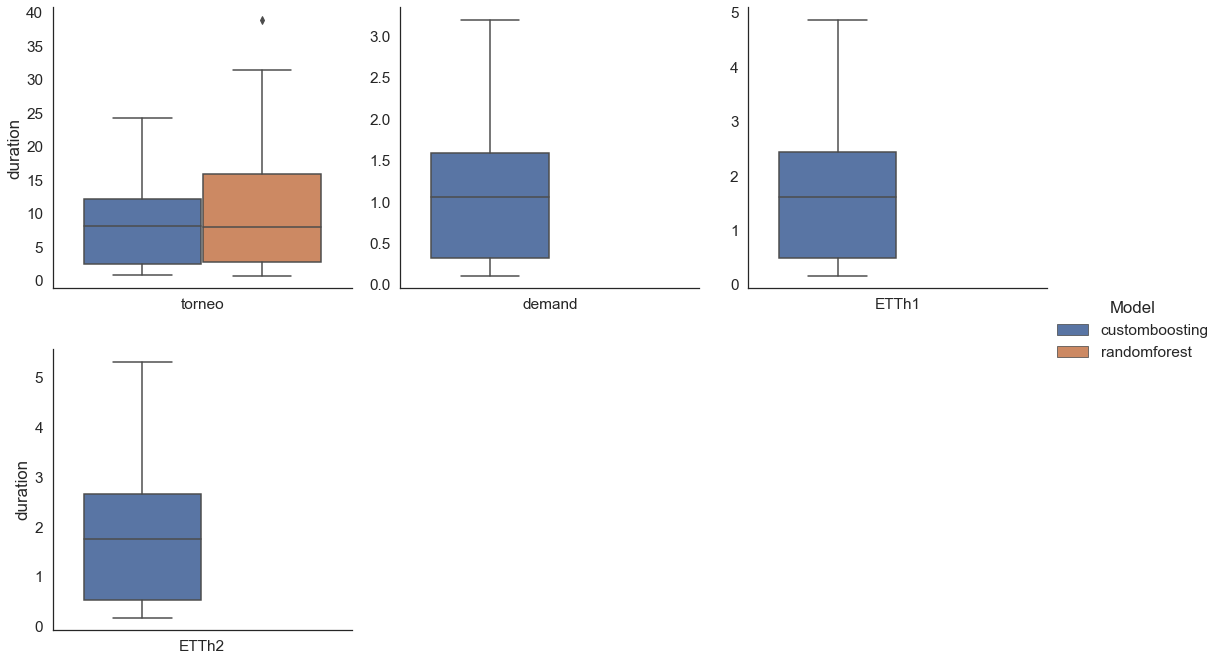

In [23]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
g = sns.catplot(data=total_metrics, kind='box', x='dataset', y="duration", col='dataset', hue='Model', sharex=False, sharey=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.show()

<Figure size 2000x2000 with 0 Axes>

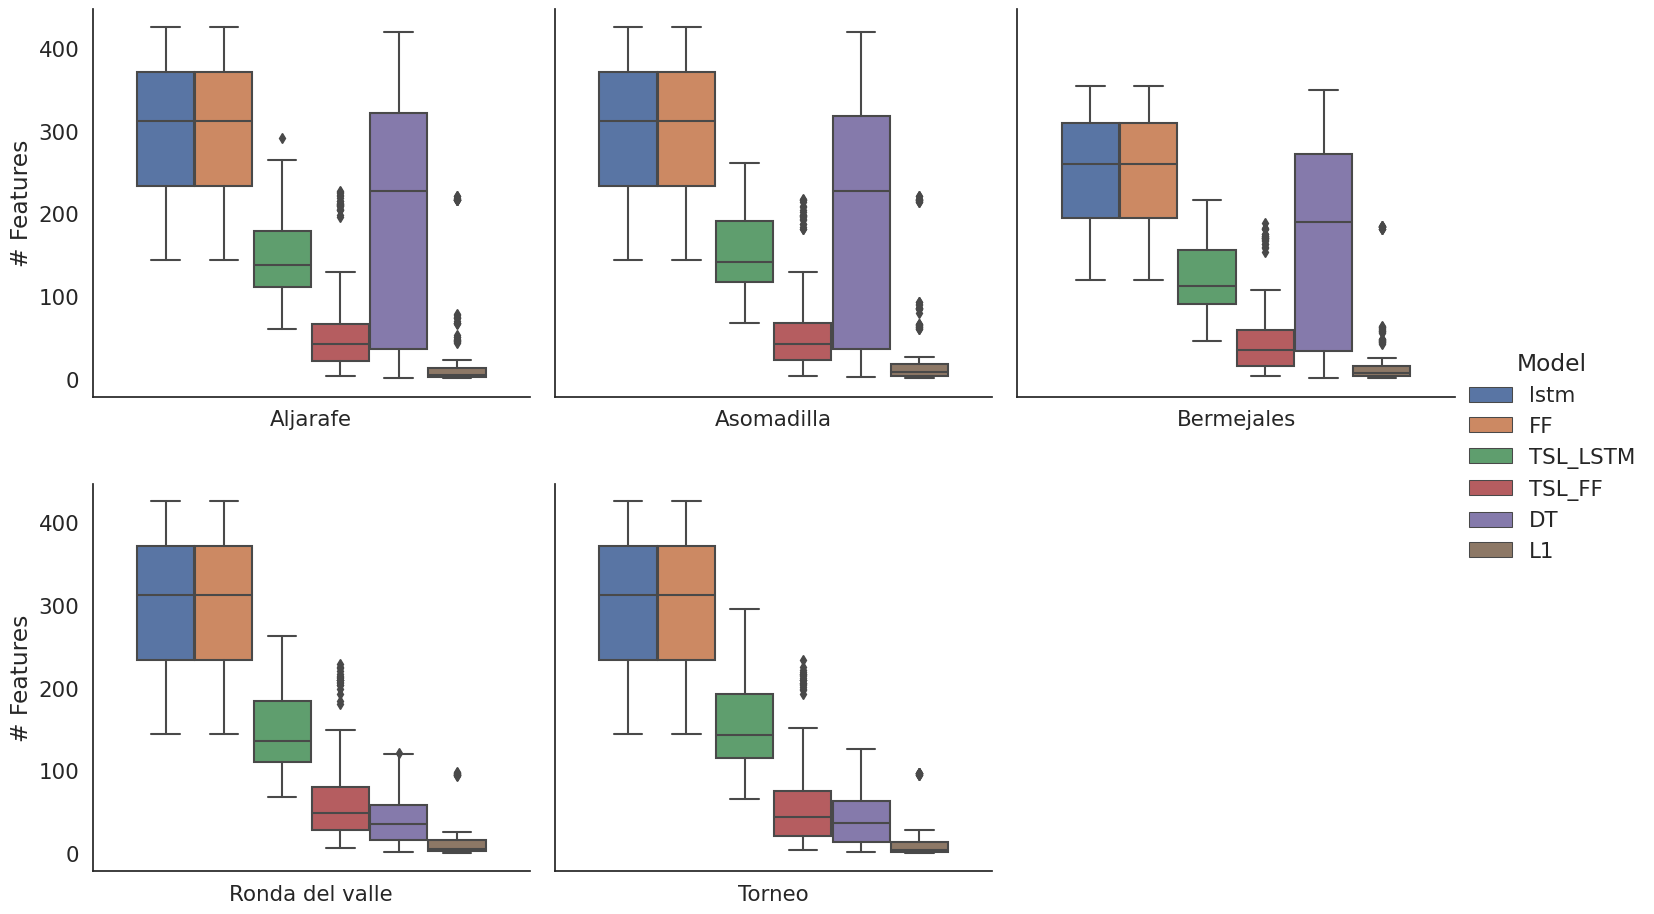

In [25]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)

g = sns.catplot(data=total_metrics[(total_metrics.dataset_params_test_year>2005)], kind='box', x='dataset', y="# Features", col='dataset', hue='Model', sharex=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.savefig('figures/boxplot_Features.png')
plt.show()
plt.show()

## Selection masks

In [1]:
sns.set(font_scale=2.8)
best_by_year_selected = best_by_year[best_by_year.dataset_params_test_year>2005]

fetures_list = ['tmp', 'vv', 'dd', 'no2', 'pm10', 'o3']
for dataset in best_by_year_selected.dataset.unique():
    results_tsl_dataset = best_by_year_selected[(best_by_year_selected.dataset==dataset) & (best_by_year_selected.model_name=='TSL+LSTM')].sort_values('dataset_params_test_year')
    results_tsl_dataset1 = best_by_year_selected[best_by_year_selected['dataset_params_test_year']==2015]
    features = results_tsl_dataset.features.apply(eval).apply(np.array).values[0]
    selected_features = results_tsl_dataset.selected_features.apply(eval).apply(np.array).values[0]

    selection_masks = []
    for feat in fetures_list:
        
        feats = features[np.core.defchararray.find(features, feat)!=-1]
        if len(feats)==0:
            continue
        sfeats = selected_features[np.core.defchararray.find(selected_features, feat)!=-1]

        
        mask = np.isin(feats, sfeats).astype(np.uint)
        selection_masks.append(mask)
    
    selection_masks = np.stack(selection_masks)
    print(selection_masks.sum()/(selection_masks.shape[0]*selection_masks.shape[1]))
    fig, ax = plt.subplots(figsize=(30,10))

    ax.set_title(f'Selected features in {dataset} for year 2015')
    cmap = sns.cm.crest_r
    g = sns.heatmap(selection_masks, yticklabels=list(map(lambda x: x.upper(), fetures_list)),cmap=cmap, xticklabels=list(map(lambda f: f.replace('target_o3 t', ''), feats.tolist())), cbar=False, linewidth=.5, ax=ax)
    plt.xticks(rotation=45)
    fig = g.get_figure()
    fig.savefig(f"figures/SelectionMasks/Ozone_{dataset}.png", bbox_inches='tight') 

NameError: name 'sns' is not defined

## Results by year

In [88]:

best_metrics = total_metrics_indexed.loc[best_index].reset_index()
best_metrics = best_metrics.groupby(['dataset', 'model_name', 'dataset_params_test_year'], dropna=False)[['root_mean_squared_error']].mean().reset_index()
best_metrics = best_metrics.rename({'dataset_params_test_year': 'year'}, axis=1)
best_metrics = best_metrics[(best_metrics.year>2005)]
best_metrics = best_metrics[best_metrics.model_name.isin(["L1", "TSL+FF", "TSL+LSTM"])]
best_metrics.pivot(index = ['year'], columns=[ 'dataset','model_name'], values='root_mean_squared_error').round(1)#.to_latex()

dataset    Aljarafe                 Asomadilla                 Bermejales  \
model_name       L1 TSL+FF TSL+LSTM         L1 TSL+FF TSL+LSTM         L1   
year                                                                        
2006           17.5   17.4     17.4       17.5   18.3     18.2       18.4   
2007           15.8   16.4     16.1       16.5   16.6     16.3       18.6   
2008           17.0   17.0     17.0       17.3   17.3     17.1       19.1   
2009           16.8   16.9     17.4       16.3   16.6     16.2       18.8   
2010           17.1   17.0     16.4       16.2   16.5     15.4       20.1   
2011           15.9   16.2     15.3       16.8   16.7     17.6       17.4   
2012           17.1   17.1     17.0       15.9   15.7     15.4       18.0   
2013           15.5   15.7     15.0       15.0   15.5     15.1       17.8   
2014           15.8   15.5     15.5       16.2   16.4     16.0       17.3   
2015           18.2   17.5     16.1       15.6   15.6     15.5       16.6   

dataset                    Ronda del valle                 Torneo         \
model_name TSL+FF TSL+LSTM              L1 TSL+FF TSL+LSTM     L1 TSL+FF   
year                                                                       
2006         18.8     18.0            20.0   19.6     19.7   13.3   13.1   
2007         19.3     18.3            19.5   19.4     19.2   13.4   13.4   
2008         18.3     18.3            20.4   20.5     20.0   13.3   13.6   
2009         19.2     18.6            19.0   19.1     18.7   14.1   14.0   
2010         19.3     19.8            20.9   19.6     20.1   14.5   14.5   
2011         17.0     17.2            18.5   18.5     18.5   14.4   14.1   
2012         18.1     18.1            15.9   15.6     15.1   15.0   14.6   
2013         17.2     17.6            17.2   17.0     16.9   14.4   14.3   
2014         17.3     17.7            17.9   17.5     17.4   14.3   14.0   
2015         16.8     17.4            17.5   17.4     17.1   14.8   14.4   

dataset              
model_name TSL+LSTM  
year                 
2006           13.5  
2007           13.3  
2008           13.4  
2009           14.1  
2010           15.1  
2011           14.0  
2012           14.5  
2013           14.0  
2014           14.1  
2015           14.3

## Bayesian tests

Aljarafe
(0.05076777275790345, 0.12935638999146104, 0.8198758372506355)
Asomadilla
(0.602895547675582, 0.10875292478995702, 0.288351527534461)
Bermejales
(0.03313082773446413, 0.12024413473288698, 0.8466250375326488)
Ronda del valle
(0.211954572140984, 0.23879189133067558, 0.5492535365283404)
Torneo
(0.9474553885433044, 0.044262588874285025, 0.00828202258241062)


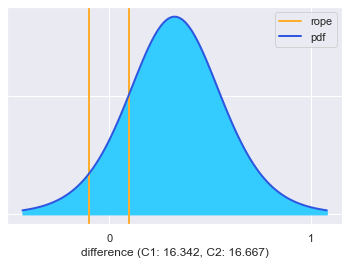

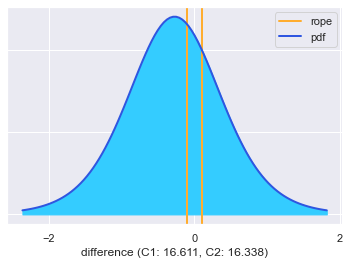

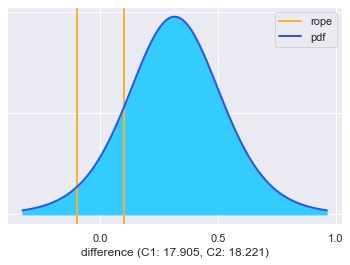

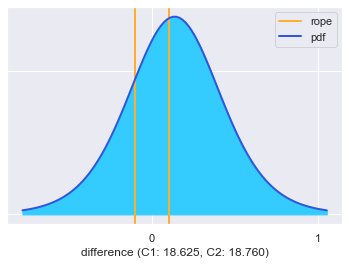

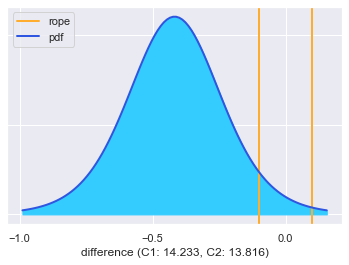

In [64]:
from baycomp import two_on_single


for dataset in best_metrics.dataset.unique():
    metrics_tsl = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='TSL')].root_mean_squared_error.values
    metrics_l1 = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='L1')].root_mean_squared_error.values
    probs, fig = two_on_single(metrics_tsl, metrics_l1, rope=0.1, plot=True)

    print(probs)
    fig.savefig(f"figures/Baytest/Baytest{dataset}.png") 

## Best hyperparameters

In [89]:
best_hyperparameters = best_index.to_frame()[['dataset', 'model_name']].reset_index(drop=True)
seq_lens = total_metrics_indexed.groupby(['dataset', 'model_name']).head(1)['dataset_params_seq_len'].reset_index(drop=True)

In [91]:
pd.set_option('display.max_colwidth', 2000)
seq_lens = total_metrics_indexed.groupby(['dataset', 'model_name']).head(1)['dataset_params_seq_len'].reset_index(drop=True)
params = list(map(lambda my_dict: {k: my_dict[k] if not my_dict[k].is_integer() else int(my_dict[k]) for k in my_dict if not isnan(my_dict[k])},best_index.to_frame()[best_index.to_frame().model_name!='TSLRes'].loc[:, ['model_params_layers', 'model_params_units', 'model_params_batch_size', 'model_params_lr','model_params_dropout',  'model_params_max_depth', 'model_params_regularization','selection_params_regularization']].to_dict('records')))
best_hyperparameters['window'] = seq_lens #
best_hyperparameters['params'] = params

best_hyperparameters[best_hyperparameters.model_name=="TSL+LSTM"].set_index(['dataset']).to_dict('index')#.to_latex('tab.tex')

{'Aljarafe': {'model_name': 'TSL+LSTM',
  'window': 31,
  'params': {'model_params_layers': 1,
   'model_params_units': 18,
   'model_params_batch_size': 44,
   'model_params_lr': 0.0058554533800052,
   'model_params_dropout': 0.3719129270375464,
   'selection_params_regularization': 0.0097002028888842}},
 'Asomadilla': {'model_name': 'TSL+LSTM',
  'window': 28,
  'params': {'model_params_layers': 1,
   'model_params_units': 36,
   'model_params_batch_size': 29,
   'model_params_lr': 0.0003802342314058,
   'model_params_dropout': 0.0099400669198977,
   'selection_params_regularization': 0.0024621860549236}},
 'Bermejales': {'model_name': 'TSL+LSTM',
  'window': 31,
  'params': {'model_params_layers': 1,
   'model_params_units': 36,
   'model_params_batch_size': 29,
   'model_params_lr': 0.0003802342314058,
   'model_params_dropout': 0.0099400669198977,
   'selection_params_regularization': 0.0024621860549236}},
 'Ronda del valle': {'model_name': 'TSL+LSTM',
  'window': 58,
  'params': 